In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)

def load_data(fpath):
    df = pd.read_csv(fpath)
    df = df.dropna()
    df = df[['Date', 'Close']]
    df['Month'] = df['Date'].map(lambda x: int(x.split('/')[0]))
    df['Day'] = df['Date'].map(lambda x: int(x.split('/')[1]))

    df['Month_sin'] = np.sin((df.Month-1)*(2*np.pi/12))
    df['Month_cos'] = np.cos((df.Month-1)*(2*np.pi/12))

    df['Day_sin'] = np.sin((df.Day-1)*(2*np.pi/31))
    df['Day_cos'] = np.cos((df.Day-1)*(2*np.pi/31))
    return df

def add_features(df):
    df['3day MA'] = df['Close'].shift(1).rolling(window = 3).mean()
    df['10day MA'] = df['Close'].shift(1).rolling(window = 10).mean()
    df['30day MA'] = df['Close'].shift(1).rolling(window = 30).mean()
    df['Std_dev']= df['Close'].rolling(5).std()

    df = df.dropna()
    return df


In [2]:
csv_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
fpath = './Data Given/' + csv_files[1]
df = load_data(fpath)
df = add_features(df)
print(df.head(5))

         Date      Close  Month  Day  Month_sin  Month_cos   Day_sin  \
30  2/17/2009  29.783264      2   17        0.5   0.866025 -0.101168   
31  2/18/2009  28.877563      2   18        0.5   0.866025 -0.299363   
32  2/19/2009  28.820360      2   19        0.5   0.866025 -0.485302   
33  2/20/2009  27.495176      2   20        0.5   0.866025 -0.651372   
34  2/23/2009  26.446470      2   23        0.5   0.866025 -0.968077   

     Day_cos    3day MA   10day MA   30day MA   Std_dev  
30 -0.994869  30.863749  30.933981  31.554624  0.627582  
31 -0.954139  30.561849  30.877732  31.445940  0.990059  
32 -0.874347  30.059741  30.744260  31.312786  1.126417  
33 -0.758758  29.160396  30.542146  31.128150  1.484985  
34 -0.250653  28.397700  30.191306  30.949870  1.312112  


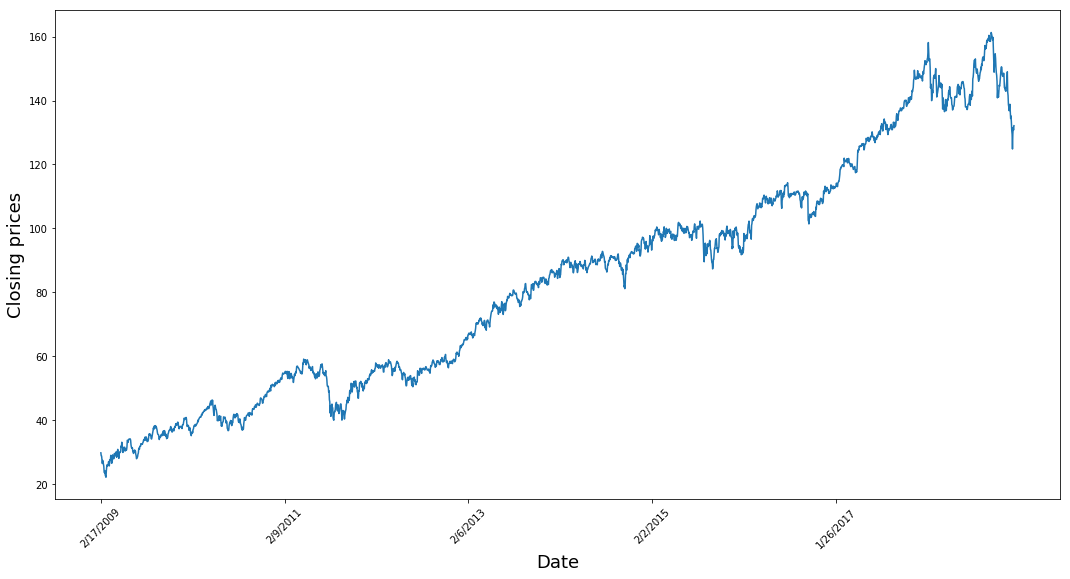

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing prices', fontsize=18)
plt.show()

In [4]:
input_features = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

split_idx = int(0.9*len(input_features))
train_data = input_features[:split_idx]
test_data = input_features[split_idx:]

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
test_set_scaled = sc.transform(test_data)


In [5]:
X_train = []
Y_train = []

chunk_size = 45
for i in range(chunk_size, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-chunk_size:i])
    Y_train.append(training_set_scaled[i, 0])
    # print(training_set_scaled[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def fit_model(X_train, Y_train):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.4))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, Y_train, epochs=3, batch_size=32)
    return model
          

In [ ]:
model = fit_model(X_train, Y_train)

Epoch 1/3
2192/2192 [==============================] - 49s 22ms/step - loss: 0.0194
Epoch 2/3
2192/2192 [==============================] - 46s 21ms/step - loss: 0.0069
Epoch 3/3
 992/2192 [============>.................] - ETA: 24s - loss: 0.0067

In [10]:
def predict_stock_prices(total_data, chunk_size, num_days, num_trailing_blanks):
    predicted_stock_prices = []

    for day in range(num_days):
        curr_idx = len(total_data) - num_trailing_blanks + day

        start_idx = len(total_data) - num_trailing_blanks - chunk_size + day
        end_idx = start_idx+chunk_size
        inputs = total_data[start_idx:end_idx]
        X_test = []
        X_test.append(inputs)

        X_test = np.array(X_test)
        # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_stock_price = model.predict(X_test)
        total_data[curr_idx][0] = predicted_stock_price
        total_data[curr_idx][5] = total_data[curr_idx-3:curr_idx, 0].mean()
        total_data[curr_idx][6] = total_data[curr_idx-10:curr_idx, 0].mean()
        total_data[curr_idx][7] = total_data[curr_idx-30:curr_idx, 0].mean()
        total_data[curr_idx][8] = total_data[curr_idx-5:curr_idx, 0].std()


        predicted_stock_price = sc.inverse_transform(total_data[curr_idx].reshape(1, -1))[0][0]
        predicted_stock_prices.append(predicted_stock_price)
        
    return predicted_stock_prices

In [11]:
num_days = 50
total_data = np.concatenate((training_set_scaled, test_set_scaled))
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(test_set_scaled))

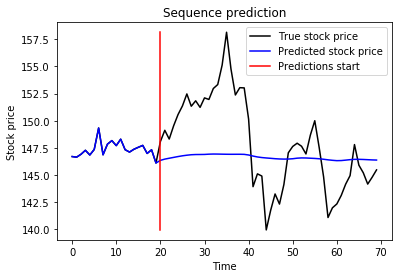

[146.35038531473245, 146.4653455451882, 146.5450746810526, 146.62313409679413, 146.70046490739122, 146.76901450806966, 146.82443403687324, 146.86767978805412, 146.88672977672806, 146.88975045222296, 146.89554893483128, 146.91988131080282, 146.931425148561, 146.92811606686308, 146.91922860202754, 146.9117907578441, 146.90829193522313, 146.90987057970287, 146.91091035996118, 146.90212156040562, 146.8440153001317, 146.7455549403441, 146.66367034759392, 146.60874414519026, 146.57086426731314, 146.53832749382903, 146.5030736303269, 146.47794434247854, 146.46658265600647, 146.47251016244246, 146.4996431144382, 146.5508731636609, 146.57495508161404, 146.5681775358428, 146.54735157212914, 146.52772477104915, 146.49647064620484, 146.45259495515944, 146.39877683974638, 146.35594092895926, 146.32309298036137, 146.33224608248915, 146.37140101936913, 146.41511732803917, 146.44313067791785, 146.44426912345614, 146.43176140180887, 146.4117930670674, 146.3914756090275, 146.3784973298911]


In [12]:
actual_line = np.concatenate((train_data[-20:, 0], test_data[:num_days, 0]))
predicted_line = np.concatenate((train_data[-20:, 0], predicted_stock_prices))

miny = min(np.min(actual_line), np.min(predicted_line))
maxy = max(np.max(actual_line), np.max(predicted_line))

plt.plot(actual_line, color='black', label='True stock price')
plt.plot(predicted_line, color='blue', label='Predicted stock price')
plt.plot((20, 20), (miny, maxy), 'k-', color='red', label='Predictions start')
plt.title("Sequence prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
print(predicted_stock_prices)

In [54]:
df = pd.read_csv('./Data Given/submission_template.csv')

df['']



df.to_csv('Team50_Undergrad.csv')